In [1]:
%matplotlib inline

import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from torch.utils.data import DataLoader
import torch
from typing import List, Literal
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
import re

from predpy.dataset import MultiTimeSeriesDataset
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import plot_anomalies, get_ids_ranges, get_cls_ids_ranges
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_dataset_names, load_anom_scores)

from notebook_utils.modeling import (
    predict, get_a_scores, get_rec_fbeta_score_conf_mat,
    get_a_scores_one_per_point, get_recon_one_per_point,
    adjust_point_cls_with_window,
    th_ws_experiment, stats_experiment,
    calculate_rec_wdd, recalculate_wdd
)
from notebook_utils.plotting import (
    plot_scores, plot_kde, plot_dataset, plot_scores_and_bands
)
from notebook_utils.save_load import (
    save_th_exp, load_th_exp
)
from notebook_utils.ts_stats import (
    get_bollinger, get_std, get_diff
)


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

# Data and model loading

In [2]:
exp = load_experimentator('./saved_experiments/2022-05-31_14:20:37.pkl')
model_id = 8
exp.models_params

,name_,cls_,init_params,WrapperCls,wrapper_kwargs,learning_params
0,TadGAN_h50_l1_z5_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 50,...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
1,TadGAN_h50_l1_z10_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 50,...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
2,TadGAN_h50_l1_z50_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 50,...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
3,TadGAN_h100_l1_z5_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 100...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
4,TadGAN_h100_l1_z10_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 100...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
5,TadGAN_h100_l1_z50_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 100...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
6,TadGAN_h100_l2_z5_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 100...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
7,TadGAN_h100_l2_z10_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 100...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
8,TadGAN_h100_l2_z50_g1d1_warm0,<class 'literature.tadgan.tadgan.TADGAN'>,"{'window_size': 200, 'c_in': 38, 'h_size': 100...",<class 'literature.tadgan.tadgan_wrapper.TADGA...,"{'gen_dis_train_loops': (1, 1), 'warmup_epochs...","{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
9,AnomTrans_l2_d2_l2,<class 'literature.anom_trans.anom_trans.Anoma...,"{'window_size': 200, 'c_in': 38, 'd_model': 2,...",<class 'literature.anom_trans.anom_trans_wrapp...,{},"{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."


In [3]:
m_name = 'TadGAN_h100_l2_z50_g1d1_warm0'
topic, colleciton_name, ds_name = 'Industry', 'ServerMachineDataset', 'machine-1-1'
exp_date = exp.exp_date
model = exp.load_pl_model(model_id, f'checkpoints/machine-1-1/{m_name}')
window_size = model.model.params['window_size']
scores_dirpath = f'notebook_a_scores/{colleciton_name}/{ds_name}/{m_name}/{exp_date}/'

In [4]:
train_ds = get_dataset(
    f'data/{topic}/{colleciton_name}/train/{ds_name}.csv',
    window_size=window_size)
test_ds = get_dataset(
    f'data/{topic}/{colleciton_name}/test/{ds_name}.csv',
    window_size=window_size)

train_dl = DataLoader(train_ds, batch_size=500)
test_dl = DataLoader(test_ds, batch_size=500)
test_index = test_ds.sequences[0].index

test_cls_path = f'saved_scores_preds/{colleciton_name}/{ds_name}/record_classes/{window_size}.csv'
test_cls = pd.read_csv(
    test_cls_path, header=None)\
    .iloc[:, 0].to_numpy()
test_point_cls_path = f'data/{topic}/{colleciton_name}/test_label/{ds_name}.csv'
test_point_cls = pd.read_csv(
    test_point_cls_path, header=None)\
    .iloc[:, 0].to_numpy()

n_features = train_ds.sequences[0].shape[1]

## Load scores

In [5]:
x_hat = np.load(scores_dirpath + 'x_hat.npy', allow_pickle=True)
x_hat_err_points = np.load(scores_dirpath + 'x_hat_err_points.npy', allow_pickle=True)
a_scores = np.load(scores_dirpath + '')

IsADirectoryError: [Errno 21] Is a directory: 'notebook_a_scores/ServerMachineDataset/machine-1-1/TadGAN_h100_l2_z50_g1d1_warm0/2022-05-31_14:20:37/'

# Dataset plotting

Plotting "machine-1-1" dataset.  
Blue is training dataset, orange is test dataset.  
Anomalies are red regions, they are present only in test dataset.  
Not all features express anomalies.  

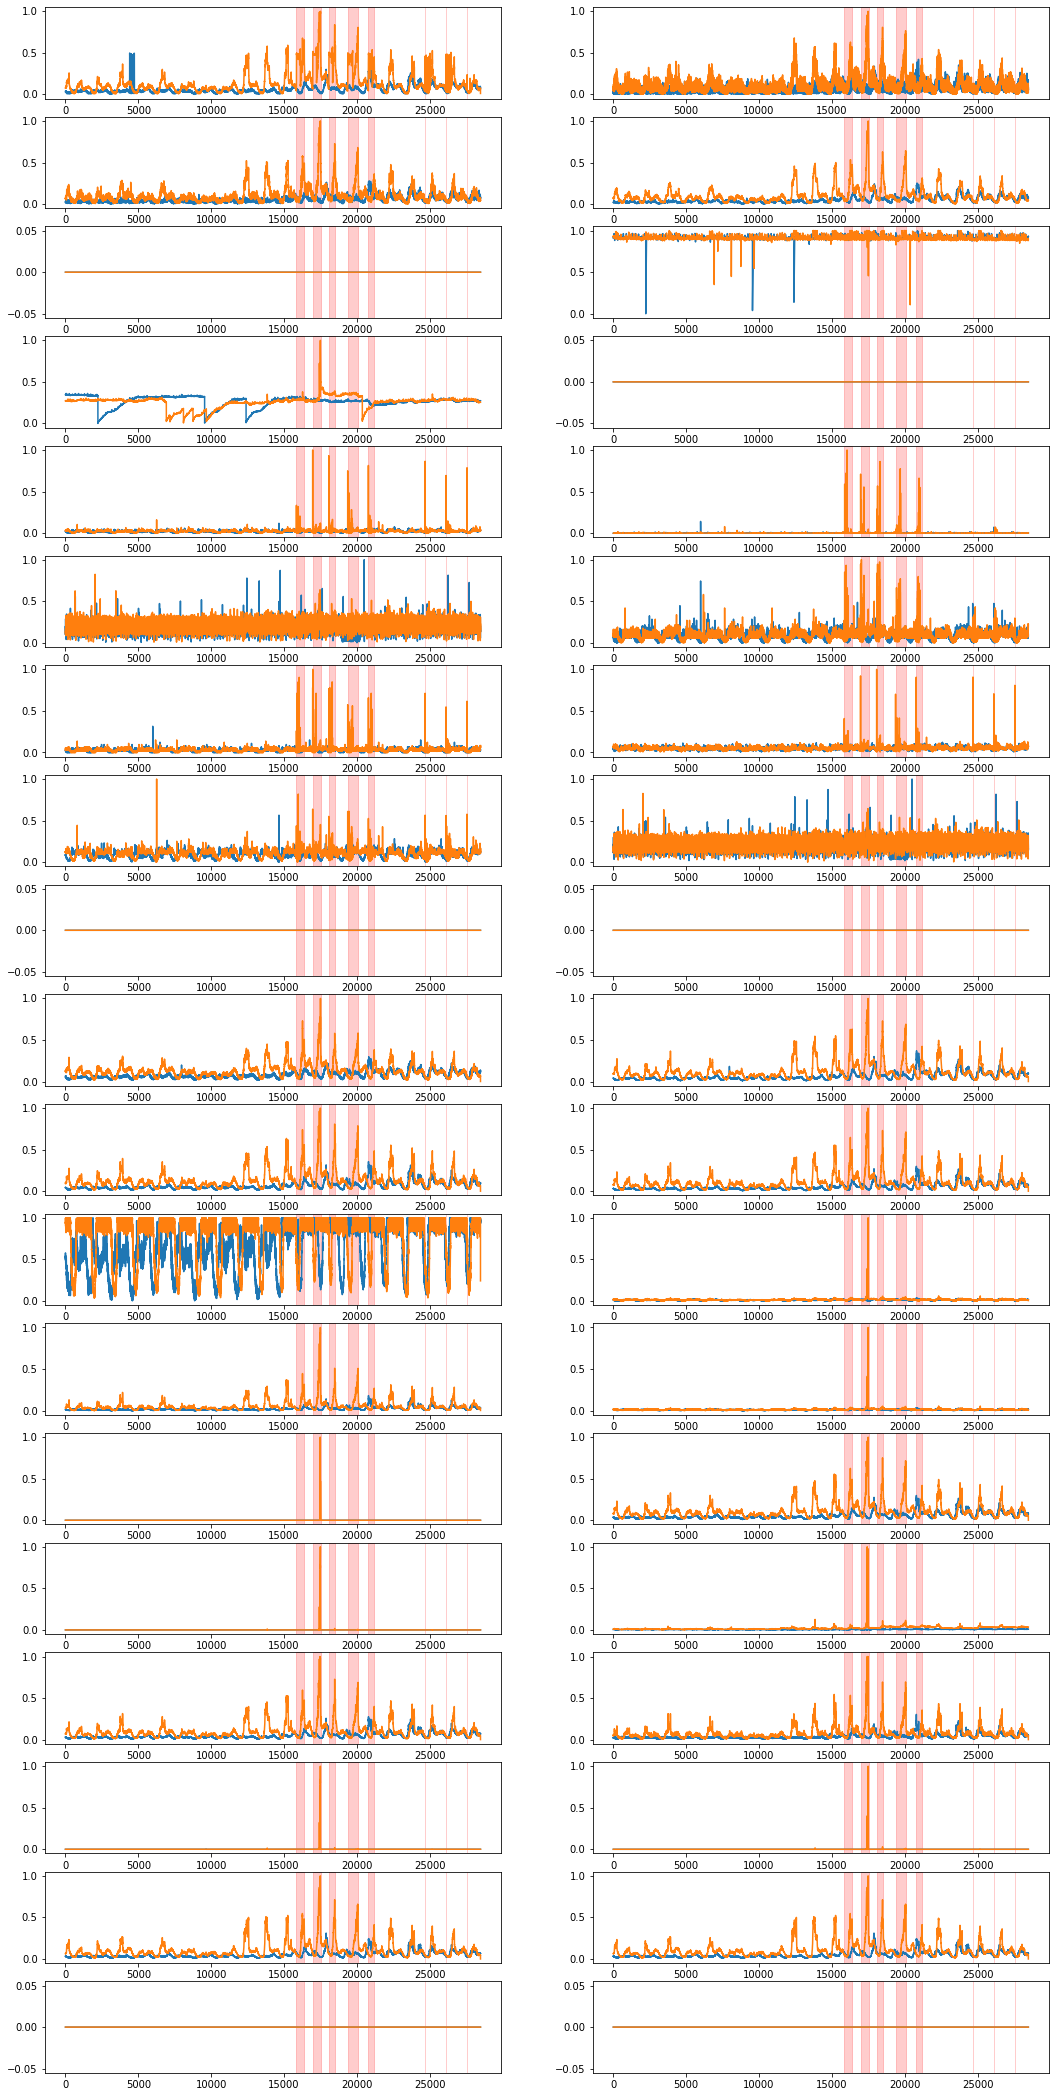

In [29]:
anoms_vrects = [
    (15849, 16368), (16963, 17517), (18071, 18528), (19367, 20088),
    (20786, 21195), (24679, 24682), (26114, 26116), (27554, 27556)]

plot_dataset(
    train_ds=train_dl.dataset.sequences[0].to_numpy(),
    test_ds=test_dl.dataset.sequences[0].to_numpy(),
    anoms_vrects=anoms_vrects);


# Collecting and storing anomaly scores

In [21]:
test_as, pred_cls = load_anom_scores(
    f'saved_scores_preds/{colleciton_name}/{ds_name}/{m_name}/anom_scores.csv')

## Computing anomaly score

Training required TadGAN scalers (rec err and critic x)

In [5]:
model.fit_scalers(DataLoader(train_ds, batch_size=1))

100%|██████████| 28279/28279 [00:31<00:00, 900.98it/s] 


Anomaly scores

In [6]:
a_scores = get_a_scores(
    model=model, dataloader=DataLoader(test_ds, batch_size=500)
)

100%|██████████| 57/57 [01:53<00:00,  2.00s/it]



Reconstruction error

In [7]:
x_hat = get_recon_one_per_point(
    model=model, dataloader=DataLoader(test_ds, batch_size=1), ws=window_size
)
x_all = test_ds.sequences[0].to_numpy()
x_hat_err_points = np.abs(x_hat - x_all)

100%|██████████| 28279/28279 [00:36<00:00, 771.65it/s]


## Saving scores

In [8]:
os.makedirs(scores_dirpath, exist_ok=True)

a_scores.dump(scores_dirpath + 'a_rec_scores.npy')
x_hat.dump(scores_dirpath + 'x_hat.npy')
x_hat_err_points.dump(scores_dirpath + 'x_hat_err_points.npy')

# Plotting scores

## KDE over train and test datasets

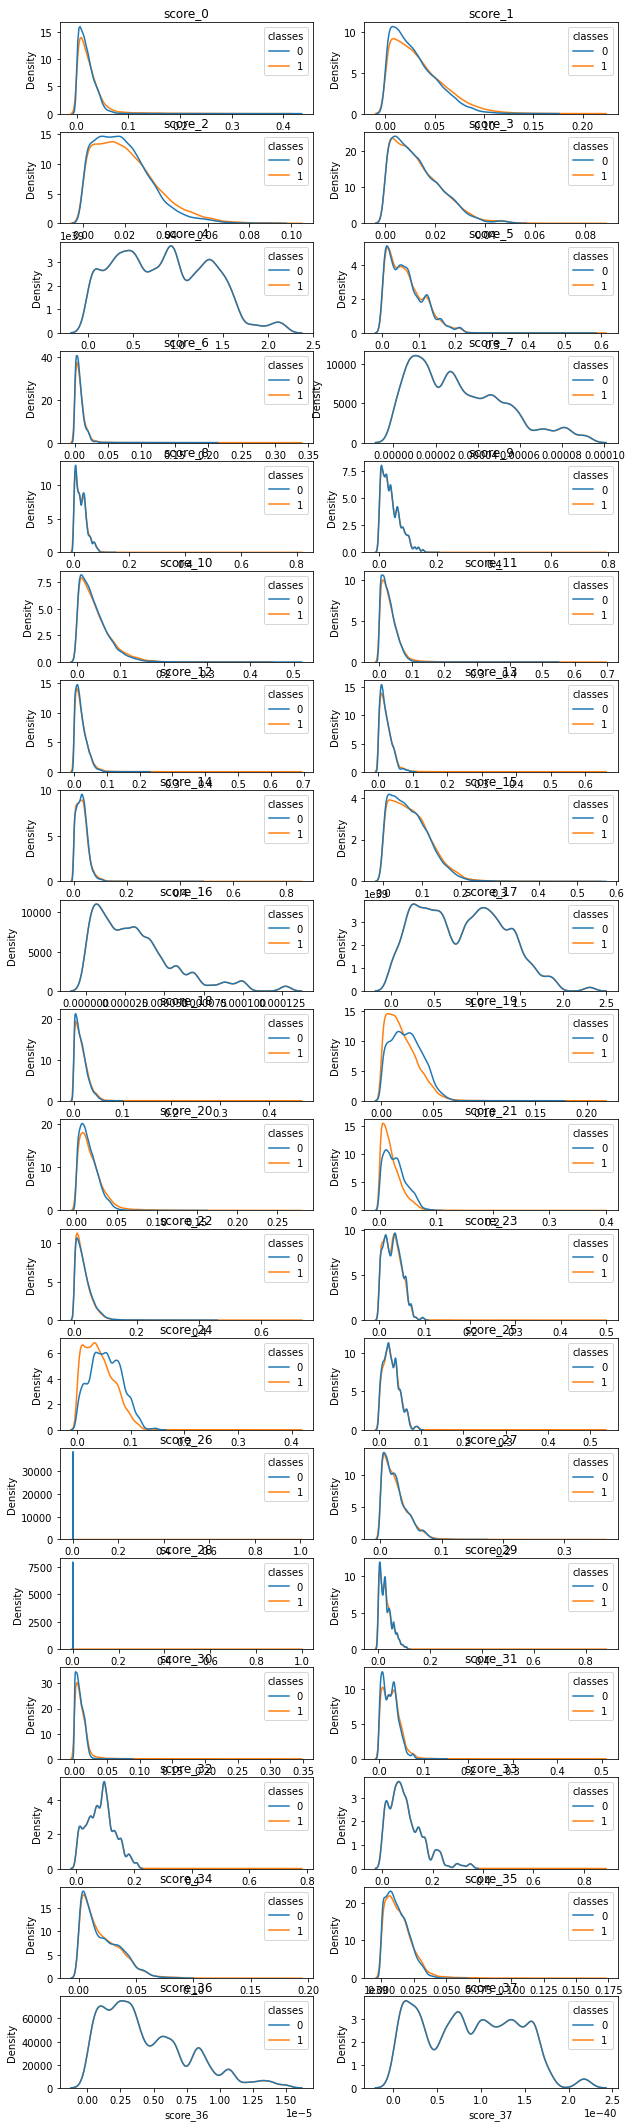

In [17]:
plot_kde(x_hat1_err_points_st, scores2=x_hat1_err_points);

## Anomaly score and rec err for points

Anomaly score

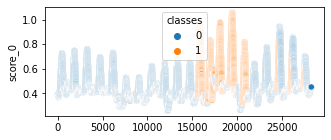

In [9]:
plot_scores(a_scores, classes=test_cls);

Recon error

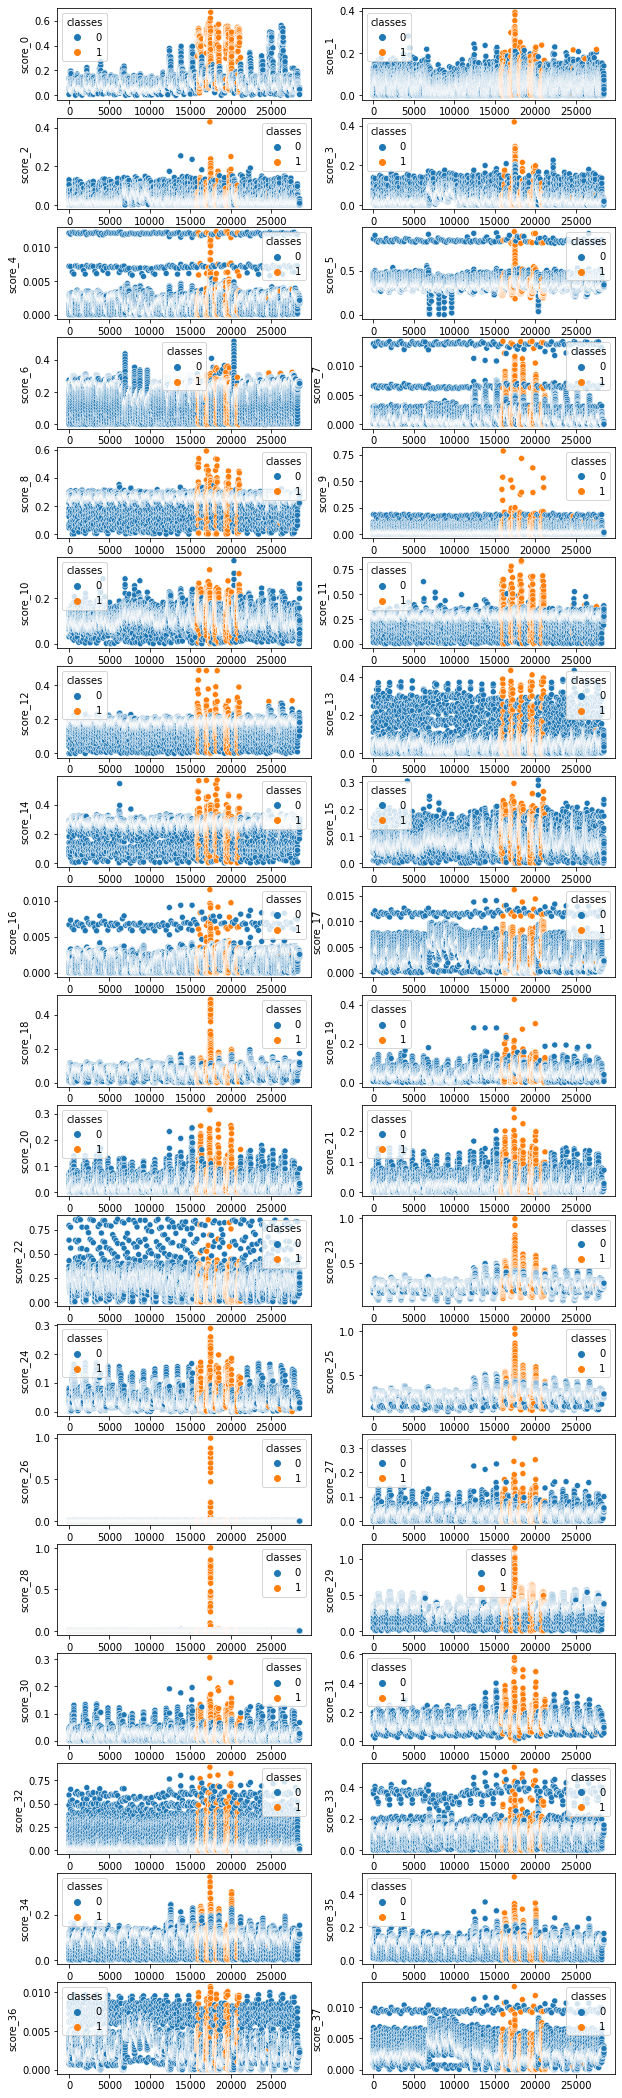

In [10]:
plot_scores(x_hat_err_points, classes=test_point_cls);

# Finding best ws and th
ws - window size  
th - threshold  
Optimizing beta score.  

## Loading computed scores

In [12]:
th_df = load_th_exp(scores_dirpath + 'th_ws_exp.csv')

## Computing and comparing scores

In [12]:
a_scores.shape

(28279, 1)

In [13]:
betas = [0.5, 1]
wss = [200, 500]  # np.arange(100, 501, 100)
ths = np.linspace(0.25, 1.25, 50)
th_df = th_ws_experiment(
    series_index=test_index, point_scores=a_scores,
    point_cls=test_cls, t_max=500,
    ths=ths, wss=wss, betas=betas)

100%|██████████| 2/2 [13:14<00:00, 397.08s/it]


Saving scores

In [28]:
# th_df.iloc[:, -1] = th_df.iloc[:, -1].apply(lambda x: np.array(x))

In [29]:
save_th_exp(th_df, scores_dirpath + 'th_ws_exp.csv')

Best f1-score for model window size

In [30]:
th_df[th_df['ws'] == window_size].sort_values('f1-score', ascending=False).head()

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
26,200,0.780612,2575.429888,0.777427,0.634839,20344,337,3801,3597,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,200,0.801020,2566.977963,0.767814,0.618975,20357,324,3937,3461,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
25,200,0.760204,2493.837758,0.685880,0.603133,19475,1206,3683,3715,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,200,0.698980,2630.424729,0.590378,0.588307,17696,2985,3071,4327,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,200,0.739796,2443.541079,0.641999,0.587327,18927,1754,3593,3805,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Best f0.5-score for model window size

In [31]:
th_df[th_df['ws'] == window_size].sort_values('f0.5-score', ascending=False).head()

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
26,200,0.780612,2575.429888,0.777427,0.634839,20344,337,3801,3597,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,200,0.801020,2566.977963,0.767814,0.618975,20357,324,3937,3461,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28,200,0.821429,2064.425575,0.721798,0.553710,20371,310,4447,2951,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
25,200,0.760204,2493.837758,0.685880,0.603133,19475,1206,3683,3715,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29,200,0.841837,1695.021211,0.668475,0.485230,20387,294,4934,2464,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Best f1-score for every window size

In [32]:
th_df.loc[th_df.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
26,200,0.780612,2575.429888,0.777427,0.634839,20344,337,3801,3597,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
76,500,0.780612,3641.970525,0.917879,0.863239,17576,337,2118,7748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Best f0.5-score for every window size

In [11]:
th_df.loc[th_df.groupby(['ws'])['f0.5-score'].idxmax()]

,f0.5-score,f1-score,ws,th,tn,fp,fn,tp
9,0.774770,0.757012,100,0.433673,23338,847,1163,3131
65,0.803443,0.770221,200,0.556122,21698,887,1647,4247
115,0.847983,0.834026,300,0.556122,20063,1000,1396,6020
165,0.861993,0.864622,400,0.556122,18763,1202,1115,7399
215,0.867261,0.883328,500,0.556122,17702,1424,828,8525


# Plotting with best th

In [1]:
# pred_cls = predict(x_hat1_err_points, 0.43, window_size)
# true_cls = adjust_point_cls_with_window(test_point_cls, window_size)
# pred_anom_intervals = get_ids_ranges(np.where(pred_cls == 1)[0])
# true_anom_intervals = get_ids_ranges(np.where(true_cls == 1)[0])
# plot_anomalies(
#     time_series=test_ds.sequences[0], predictions=pd.DataFrame(x_hat1),
#     pred_anomalies_intervals=pred_anom_intervals, true_anomalies_intervals=true_anom_intervals,
#     is_ae=False)

# Searching for descriptive statistics

## Moving std diff

### Loading scores

In [9]:
std_th_df = load_th_exp(scores_dirpath + 'std_th_exp-long_ws.csv')

### Computing and comparing scores

In [16]:
# bounds = [
#     get_diff(get_bollinger(x_hat1_err_points, ws, m))
#     for ws, m in [(100, 30), (200, 30), (300, 30), (400, 30)]
# ]
# ws_list = [100, 200, 300, 400]
ws_list = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
bounds = [
    get_diff(get_std(a_scores, ws))
    for ws in ws_list
]

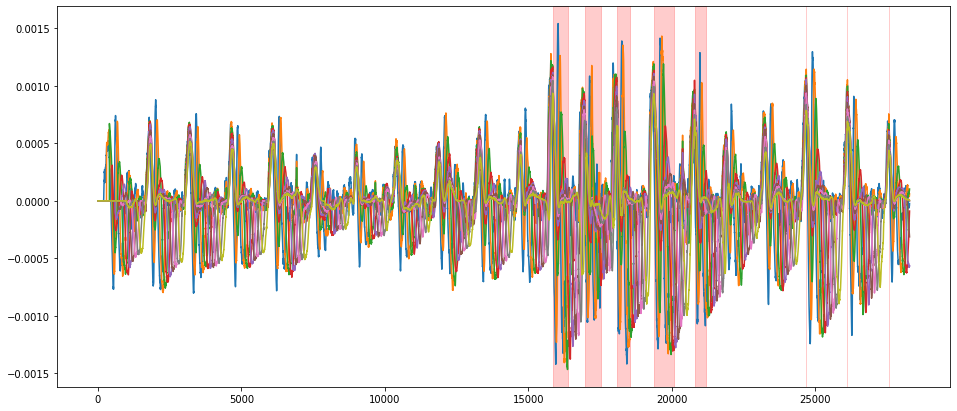

In [17]:
plot_dataset(
    {b.name: b for b in bounds},
    get_ids_ranges(np.where(test_point_cls == 1)[0]),
    figsize=(16, 7),  # min_id=24600, max_id=24750
);

In [39]:
betas = [0.5, 1]
ths = np.linspace(0.0005, 0.0015, 21)

std_th_df = stats_experiment(
    series_index=test_index, t_max=None,
    point_scores_list=bounds, point_cls=test_cls,
    ths_list=[ths] * len(ws_list), ws_list=ws_list, betas=betas)

100%|██████████| 9/9 [00:20<00:00,  2.24s/it]


In [ ]:
save_th_exp(std_th_df, scores_dirpath + 'std_th_exp-long_ws.csv')

In [40]:
std_th_df.loc[std_th_df.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
7,200,0.00085,None,0.769512,0.694032,19775,906,2985,4413,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28,300,0.00085,None,0.869137,0.814126,18862,618,2240,6259,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
47,400,0.00075,None,0.894184,0.830658,18191,422,2384,6882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
67,500,0.00070,None,0.936580,0.874289,17781,132,2101,7765,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
88,600,0.00070,None,0.956123,0.907678,17137,76,1706,8760,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
108,700,0.00065,None,0.974587,0.938800,16837,0,1239,9503,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
128,800,0.00060,None,0.979426,0.950106,16537,0,1040,9902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
148,900,0.00055,None,0.983322,0.959324,16237,0,871,10271,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169,1000,0.00055,None,0.983756,0.960356,15937,0,865,10477,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [41]:
std_th_df.loc[std_th_df.groupby(['ws'])['f0.5-score'].idxmax()]

,ws,th,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
17,200,0.000091,0.941820,0.866724,22399,2,1381,4497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32,300,0.000067,0.958354,0.902408,20773,2,1315,6089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,400,0.000057,0.970778,0.930189,19574,1,1109,7395,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
67,500,0.000043,0.990001,0.975696,18707,2,438,8832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
87,600,0.000043,0.982061,0.956329,18009,0,826,9044,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
106,700,0.000038,0.965823,0.918724,17309,0,1574,8896,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
123,800,0.000024,0.925054,0.913882,16240,695,1119,9625,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
145,900,0.000034,0.839436,0.676503,16635,0,5350,5594,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
163,1000,0.000024,0.765860,0.634838,15641,694,5639,5505,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Plotting best thresholds

#### WS = 500

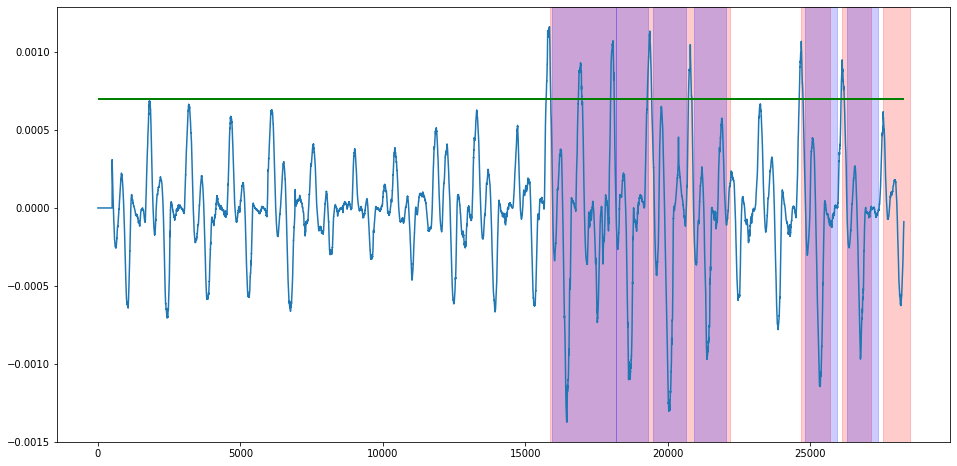

In [41]:
tmp_true_cls = adjust_point_cls_with_window(
    test_point_cls, 500, return_point_cls=False)

plot_dataset(
    ds={'std_500': bounds[3]},
    anoms_vrects=get_cls_ids_ranges(test_index, tmp_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df.loc[67, 'preds_rec_cls']),
    hlines={'threshold': std_th_df.loc[67, 'th']},
    figsize=(16, 8)
);

#### WS = 400

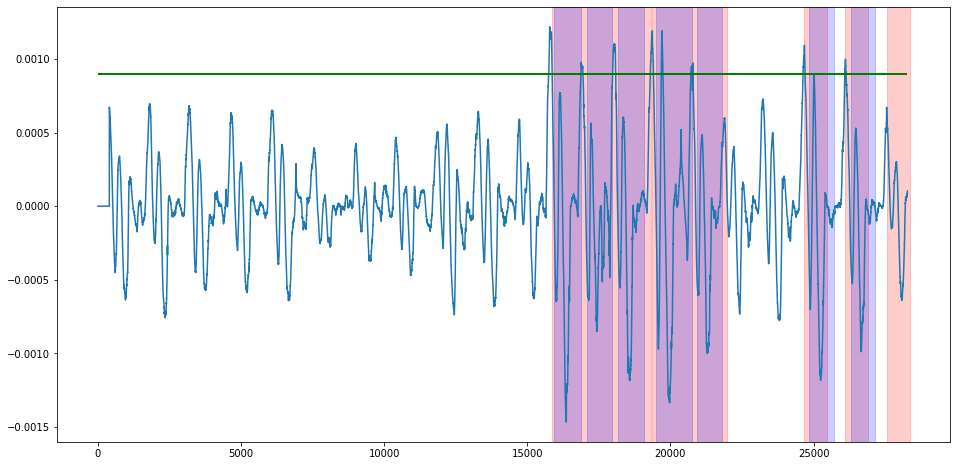

In [42]:
tmp_true_cls = adjust_point_cls_with_window(
    test_point_cls, 400, return_point_cls=False)

plot_dataset(
    ds={'std_400': bounds[2]},
    anoms_vrects=get_cls_ids_ranges(test_index, tmp_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df.loc[50, 'preds_rec_cls']),
    hlines={'threshold': std_th_df.loc[50, 'th']},
    figsize=(16, 8)
);

#### WS = 200

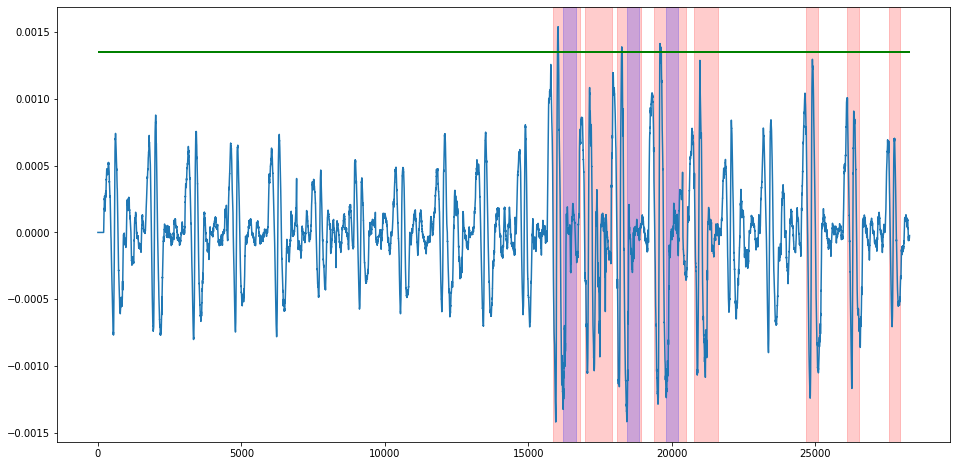

In [43]:
tmp_true_cls = adjust_point_cls_with_window(
    test_point_cls, 200, return_point_cls=False)

plot_dataset(
    ds={'std_200': bounds[0]},
    anoms_vrects=get_cls_ids_ranges(test_index, tmp_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df.loc[17, 'preds_rec_cls']),
    hlines={'threshold': std_th_df.loc[17, 'th']},
    figsize=(16, 8)
);

In [44]:
save_th_exp(std_th_df, scores_dirpath + 'std_th_exp-long_ws.csv')

In [58]:
sub_std_th_df = std_th_df[(std_th_df['ws'] == 200) | (std_th_df['ws'] == 500)]

In [61]:
sub_std_th_df['ws'].unique()

array([200, 500])

In [75]:
sub_std_th_df.loc[sub_std_th_df.groupby(['ws'])['f0.5-score'].idxmax()]
# sub_std_th_df.sort_values('wdd', ascending=False).head()

,ws,th,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls,wdd
17,200,0.000091,0.941820,0.866724,22399,2,1381,4497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2267.446398
67,500,0.000043,0.990001,0.975696,18707,2,438,8832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3681.739401


In [70]:
recalculate_wdd(sub_std_th_df, test_index, test_point_cls, t_max=500)

/tmp/ipykernel_20174/4266759851.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
save_th_exp(sub_std_th_df, scores_dirpath + 'std_th_exp-200_500.csv')

/home/stachu/Projects/Anomaly_detection/TSAD/notebook_utils/save_load.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

